In [ ]:
# data format: city, state usps code, list of counties
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
    #('Jacksonville', 'fl', ['Duval County, FL']),
    #('Fort Worth', 'tx', ['Tarrant County, TX']),
]

cities_test = [
    ('Chicago', 'il', ['Cook County, IL']),
]

In [1]:
import math
import pandas as pd
import statsmodels.api as sm
from sttn.network import SpatioTemporalNetwork
from sklearn.metrics import mean_squared_error
from skmob.models import Gravity

def fit_gravity_model(fdf, deterrence='power_law'):
    gravity_singly_fitted = Gravity(gravity_type='singly constrained', deterrence_func_type=deterrence)
    gravity_singly_fitted.fit(fdf, relevance_column='relevance')
    return gravity_singly_fitted

def compute_weights(network, job_column):
    comp_aggs={job_column: 'sum'}
    # outgoing=False corresponds to jobs, outgoing=True corresponds to population 
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'relevance'})
    outflow = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True, include_cycles=False).rename(columns={job_column: 'outflow'})
    with_jobs = network.join_node_labels(jobs).join_node_labels(outflow)
    return with_jobs

def explode_fdf(fdf):
    ids = fdf.tessellation['tile_ID']
    product = pd.MultiIndex.from_product((ids, ids))
    product.rename(['origin', 'destination'], inplace=True)
    product_df = product.to_frame()
    indexed_fdf = fdf[['origin', 'destination', 'flow']].set_index(['origin', 'destination'])
    result = indexed_fdf.join(product_df, how = 'outer', lsuffix='_left', rsuffix='_right').reset_index(drop=True)
    result.tessellation = fdf.tessellation
    return result.fillna(0)
    

def extract_model_exponents(network, deterrence='power_law'):
    columns = ['SE01', 'SE02', 'SE03']
    result = {}
    for column in columns:
        with_weights = compute_weights(network, column)
        fdf = with_weights.to_flow_date_frame(flow=column)
        exlploded_fdf = explode_fdf(fdf)
        model = fit_gravity_model(exlploded_fdf, deterrence)
        result[column] = model.deterrence_func_args[0]
    
    return result

In [4]:
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
provider = OriginDestinationEmploymentDataProvider()

model_weights = {}
for city, state, conties in cities_test:
    print('Processing {city}'.format(city=city))
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    zip_city_network = city_network.group_nodes('zip')
    city_network = zip_city_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
    exponents = extract_model_exponents(city_network)
    model_weights[city] = exponents

Processing Chicago


In [5]:
state_network = provider.get_data(state='ca', year=2018)
city_network = state_network.filter_nodes(state_network.nodes.county.isin(['Los Angeles County, CA']))
zip_city_network = city_network.group_nodes('zip')
city_network = zip_city_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
with_weights = compute_weights(city_network, 'SE01')
fdf = with_weights.to_flow_date_frame(flow='SE01')

In [ ]:
extract_model_exponents(city_network)

In [ ]:
exlploded_fdf = explode_fdf(fdf)
model = fit_gravity_model(exlploded_fdf)

## Power-law, jobs as weight

In [144]:
df = pd.DataFrame(model_weights).transpose().reset_index().rename(columns={'index':'city'})
df

,city,SE01,SE02,SE03
0,New York City,-1.045004,-1.013961,-0.890560
1,Los Angeles,-1.328642,-1.325702,-1.240705
2,Chicago,-1.215086,-1.184670,-1.029906
3,Houston,-1.127777,-1.165333,-1.063986
4,Boston,-1.236859,-1.215996,-1.051531
5,Phoenix,-1.010152,-0.972995,-0.986783
6,Philadelphia,-0.807845,-0.757486,-0.646055
7,San Antonio,-0.791390,-0.797374,-0.731361
8,San Diego,-1.142119,-1.087901,-1.039761
9,Dallas,-0.921473,-0.976293,-0.835420


<AxesSubplot:xlabel='city'>

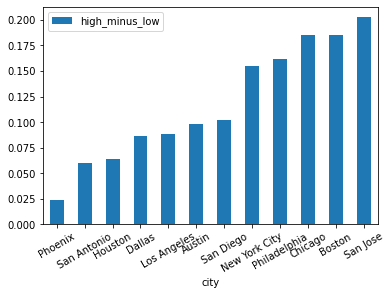

In [145]:
df['high_minus_low'] = df.SE03 - df.SE01
df.sort_values('high_minus_low').plot.bar(x='city', y='high_minus_low', rot=30)